##### <p style="text-align: center;"> ![alt text](utilities/cilss.png)</p>
# <p style="text-align: center;">AGHRYMET RCC-WAS</p>
#### &copy; Mandela HOUNGNIBO 2024 (Find more [here](https://github.com/hmandela))

## Library

In [1]:
from wass2s import *
import importlib
from pathlib import Path
import warnings
import gc
warnings.filterwarnings("ignore")

#### Set forecast working directory

In [2]:
# Set forecast working directory
dir_s2s = "./"

In [3]:
dir_s2s = Path(dir_s2s)
os.makedirs(dir_s2s, exist_ok=True)
### Save score
dir_save_score = f"{dir_s2s}/scores"
os.makedirs(dir_save_score, exist_ok=True)

#### Set Climatological Years

In [4]:
# Set Climatological Years
clim_year_start = 1994 #1991
clim_year_end = 2016 #2020
dist_method="lognormal" # "gamma", "t", "lognormal", "norm", "nonparam", "weibull_min"

## Download Observation and Process 


#### Load Downloader 

In [5]:
# Load WAS_S2S downloader class
downloader = WAS_Download()

In [6]:
# Filter observation names to identify precipitation-related models
variables_obs = [key for key in downloader.AgroObsName().keys() if "PRCP" in key]

# Specify the directory to save downloaded model data
dir_to_save_Obs = f"{dir_s2s}/Observation"

# choose sequence corresponding to seasonal forecast targets (JAS season in this case)
season_obs = ["07", "08", "09"]  # July-August-September forecast period

# Define the observation period (years 1993 to 2016)
year_start = 1991
year_end = 2024

# Set the bounding box for the area of interest (latitude and longitude bounds)
extent_obs = [21, -26, 4, 25]  # [Northern, Western, Southern and Eastern] 

# Specify whether to overwrite existing files when downloading data
force_download = False

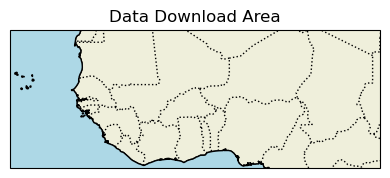

In [7]:
plot_map([extent_obs[1],extent_obs[3],extent_obs[2],extent_obs[0]], title="Data Download Area", fig_size=(4,3))

In [8]:
downloader.WAS_Download_AgroIndicators(
    dir_to_save_Obs,
    variables_obs,
    year_start,
    year_end,
    extent_obs,
    season_obs,
    force_download
)

JAS_2025_ic_5/Observation/Obs_PRCP_1991_2024_JulAugSep.nc already exists. Skipping download.


In [9]:
#### Process predictant
rainfall = prepare_predictand(dir_to_save_Obs, variables_obs, year_start, year_end, season_obs, ds=False, daily=False)
season_str = "".join([calendar.month_abbr[int(month)] for month in season_obs])

#### Process Obs in combining with Seasonal cumulative Ground-Observation

In [10]:
# ## Path to the CPT file
cpt_input_file_path = "./JAS_2025/JAS_REGIONAL.csv"

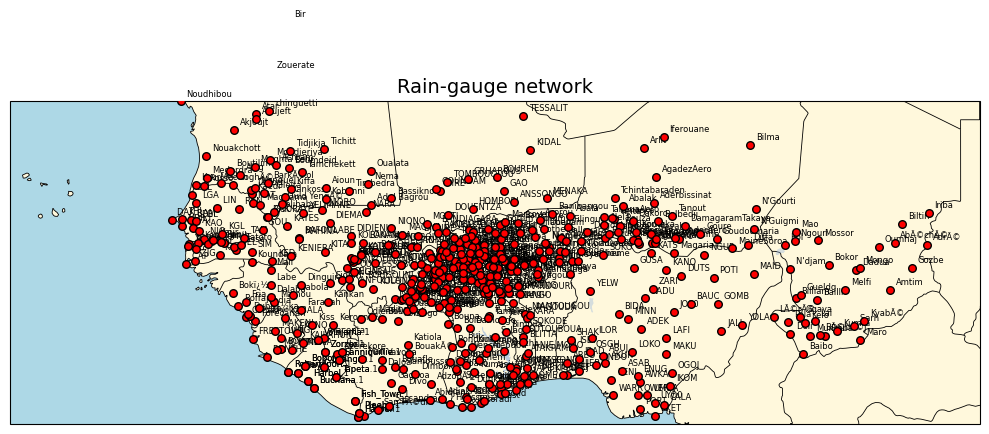

In [11]:
# ## Read CSV
df = pd.read_csv(cpt_input_file_path, na_values=-999.0,  encoding="latin1")
df_filtered = df[(df['STATION'] == 'LAT') | (df['STATION'] == 'LON') | 
                 (pd.to_numeric(df['STATION'], errors='coerce').between(year_start, year_end))]
verify_station_network(df_filtered, extent_obs)

In [12]:
da = prepare_predictand(dir_to_save_Obs, variables_obs, year_start, year_end, season_obs,  ds=False).sel(T=slice(str(year_start),str(year_end)))

In [13]:
# ## Instantiate WAS_Merging class
data_merger = WAS_Merging(df_filtered, da, date_month_day= '08-01')
rainfall__, _ = data_merger.simple_bias_adjustment(do_cross_validation=False)


Year = 1991-08-01T00:00:00.000000000, number in-situ = 523

Year = 1992-08-01T00:00:00.000000000, number in-situ = 511

Year = 1993-08-01T00:00:00.000000000, number in-situ = 521

Year = 1994-08-01T00:00:00.000000000, number in-situ = 522

Year = 1995-08-01T00:00:00.000000000, number in-situ = 526

Year = 1996-08-01T00:00:00.000000000, number in-situ = 527

Year = 1997-08-01T00:00:00.000000000, number in-situ = 525

Year = 1998-08-01T00:00:00.000000000, number in-situ = 527

Year = 1999-08-01T00:00:00.000000000, number in-situ = 530

Year = 2000-08-01T00:00:00.000000000, number in-situ = 528

Year = 2001-08-01T00:00:00.000000000, number in-situ = 520

Year = 2002-08-01T00:00:00.000000000, number in-situ = 527

Year = 2003-08-01T00:00:00.000000000, number in-situ = 527

Year = 2004-08-01T00:00:00.000000000, number in-situ = 522

Year = 2005-08-01T00:00:00.000000000, number in-situ = 522

Year = 2006-08-01T00:00:00.000000000, number in-situ = 525

Year = 2007-08-01T00:00:00.000000000, n

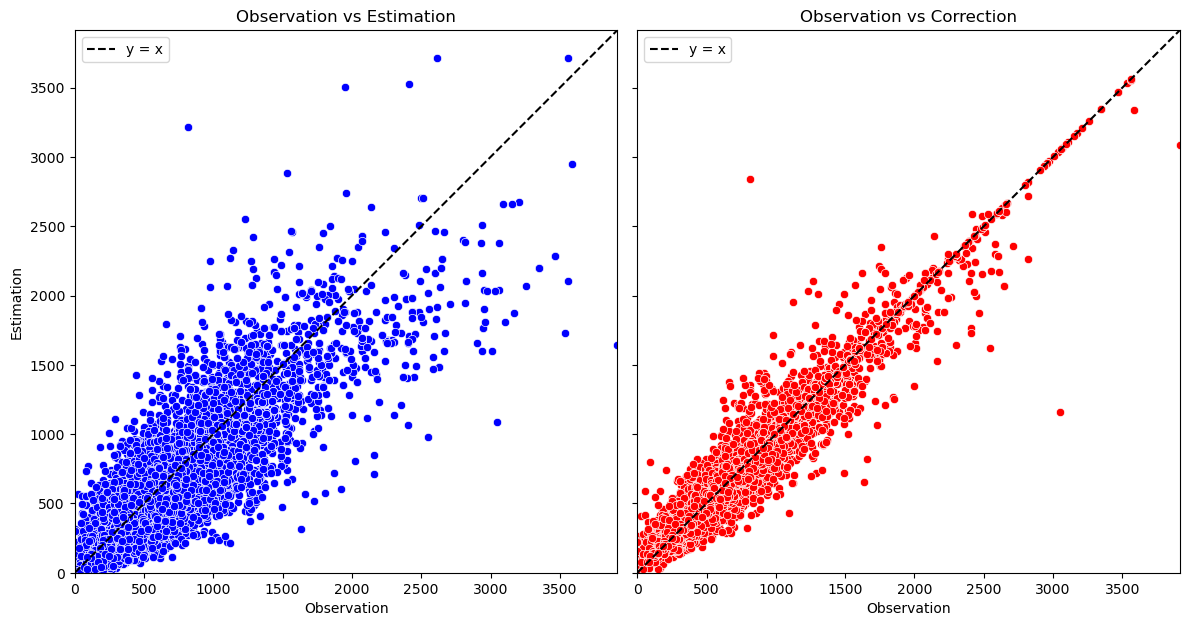

In [14]:
data_merger.plot_merging_comparaison(df_filtered, da, rainfall__)

In [15]:
rainfall = rainfall__

# 1st - Approach: Choice of Best Dynamical models and weighted Average

In [17]:
# Filter model names to identify precipitation-related models
center_variable = [key for key in downloader.ModelsName().keys() if "PRCP" in key]
center_variable.remove('UKMO_603.PRCP')
center_variable.remove('DWD_21.PRCP')
center_variable.remove('METEOFRANCE_8.PRCP')
# Specify the directory to save downloaded model data
dir_to_save_model = f"{dir_s2s}/model_data"

# Define the month for model initialization (June)
month_of_initialization = "05"

# Define lead times corresponding to seasonal forecast targets (JAS season in this case)
lead_time = ["02", "03", "04"]  # July-August-September forecast period

# Define the hindcast period for model data (years 1993 to 2016)
year_start_model = 1993
year_end_model = 2016

# Set the bounding box for the area of interest (latitude and longitude bounds)
extent = [21, -26, 4, 25] # [Northern, Western, Southern and Eastern] 

# Define if you want to download forecast or hindcast
forecast = None

# Define if you want all members of ensemble or doing an ensemble mean
ensemble_mean = "mean"

# Specify whether to overwrite existing files when downloading data
force_download = False

In [18]:
hindcast_files = downloader.WAS_Download_Models(
    dir_to_save_model,
    center_variable,
    month_of_initialization,
    lead_time,
    year_start_model,
    year_end_model,
    extent, 
    forecast,
    ensemble_mean,
    force_download)

JAS_2025_ic_5/model_data/hindcast_bom2_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_ecmwf51_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_ukmo604_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_meteofrance9_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_dwd22_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_cmcc35_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_ncep2_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_jma3_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_eccc4_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/hindcast_eccc5_PRCP_MayIc_JulAugSep_02.nc alrea

In [19]:
forecast = 2025

In [20]:
forecast_files = downloader.WAS_Download_Models(
    dir_to_save_model,
    center_variable,
    month_of_initialization,
    lead_time,
    year_start_model,
    year_end_model,
    extent, 
    forecast,
    ensemble_mean,
    force_download)

JAS_2025_ic_5/model_data/forecast_bom2_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_ecmwf51_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_ukmo604_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_meteofrance9_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_dwd22_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_cmcc35_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_ncep2_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_jma3_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_eccc4_PRCP_MayIc_JulAugSep_02.nc already exists. Skipping download.
JAS_2025_ic_5/model_data/forecast_eccc5_PRCP_MayIc_JulAugSep_02.nc alrea

In [21]:
was_verify = WAS_Verification(dist_method=dist_method)

#### Validation of GCM

In [22]:
score = ["Pearson", "MAE", "GROC"]

Pearson Correlation


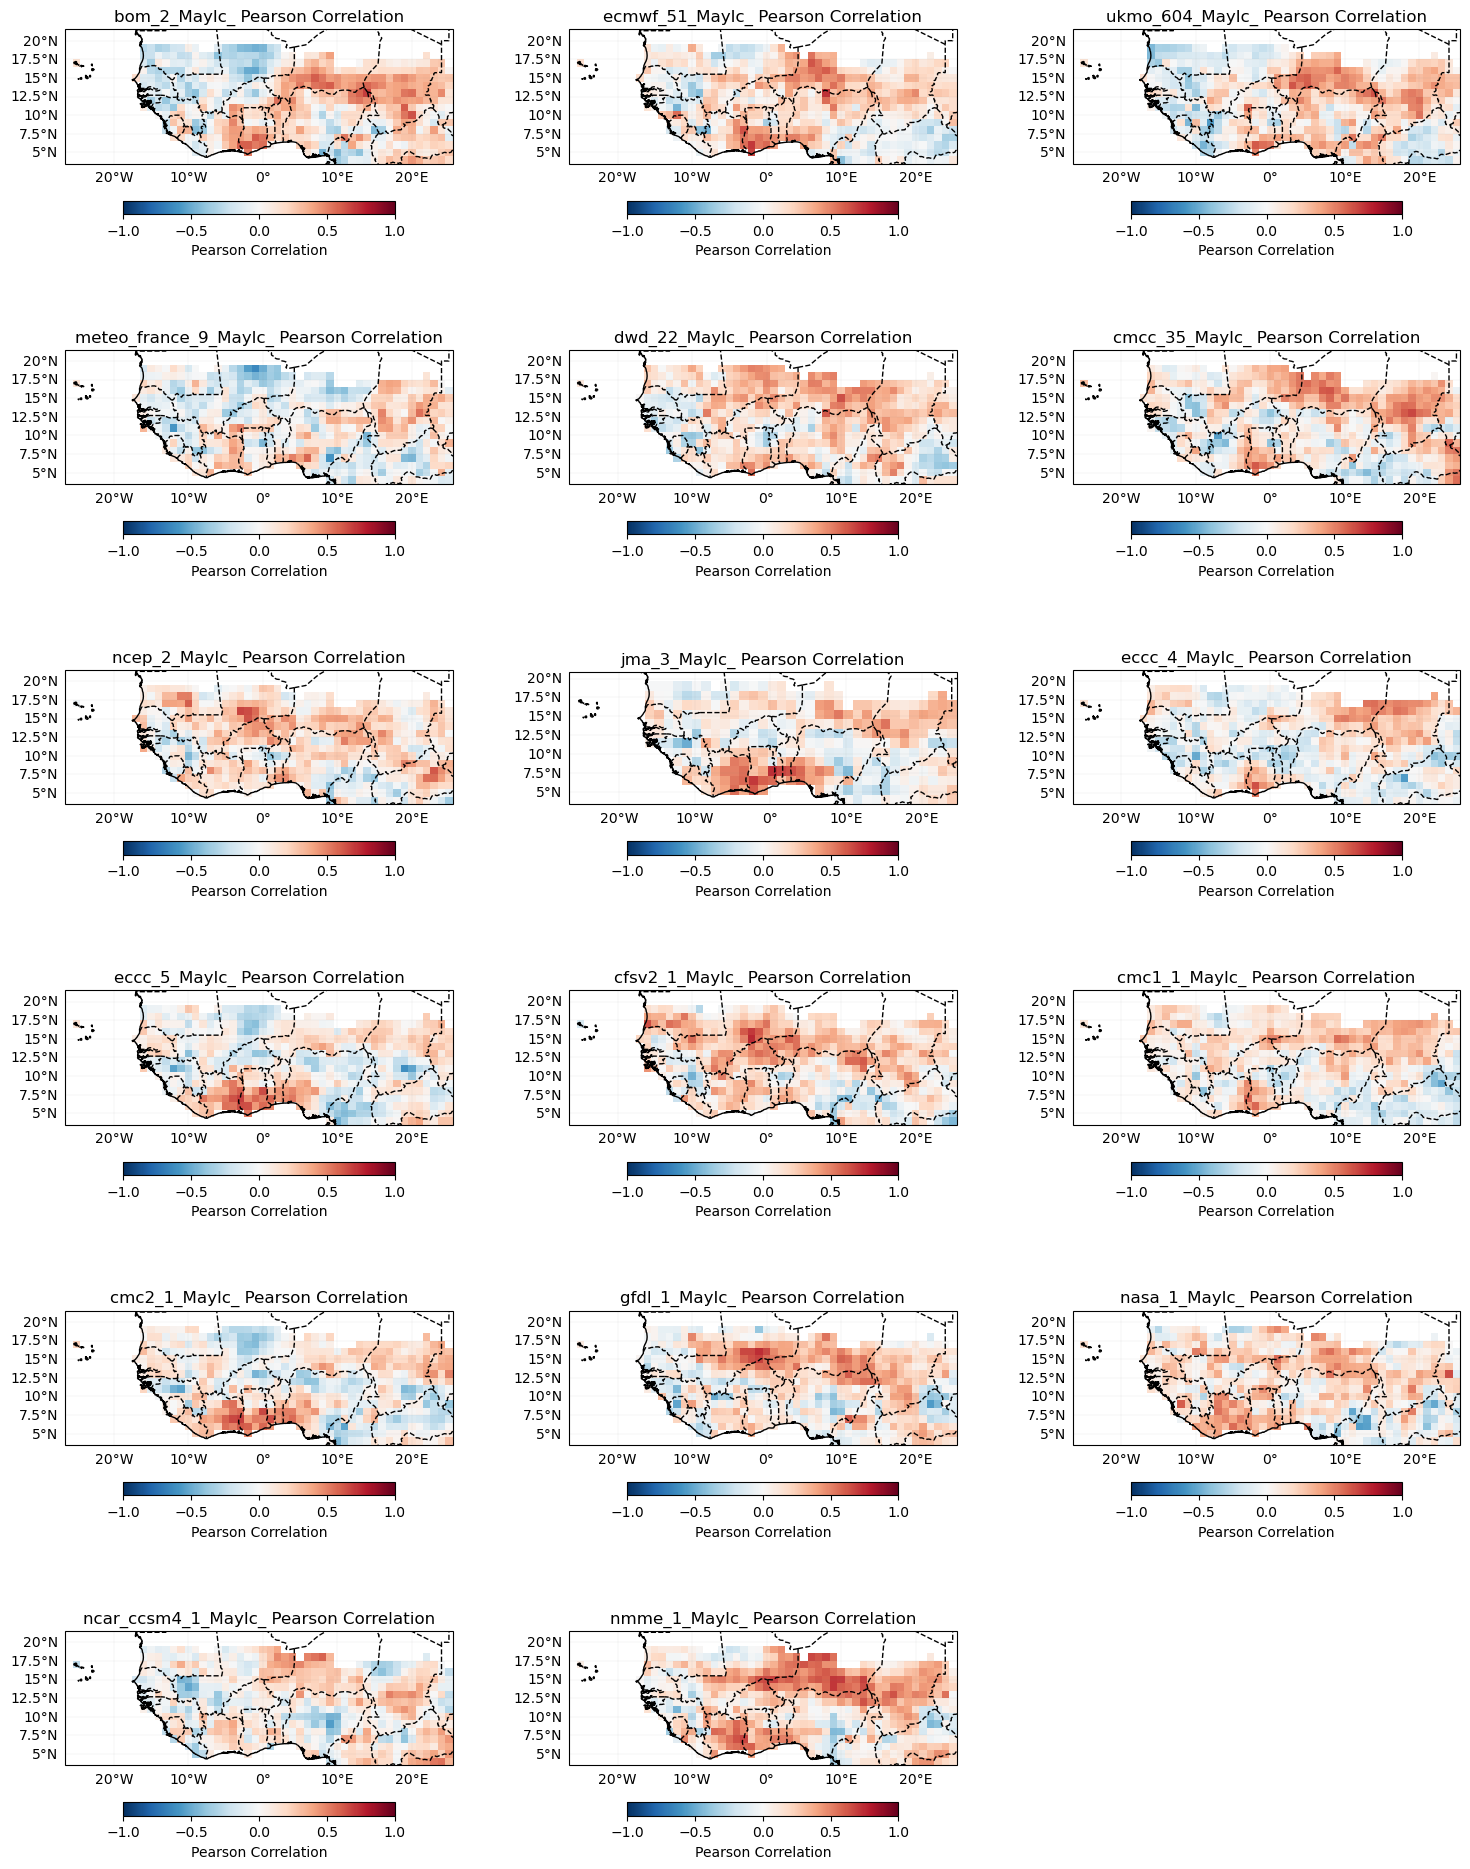

Mean Absolute Error


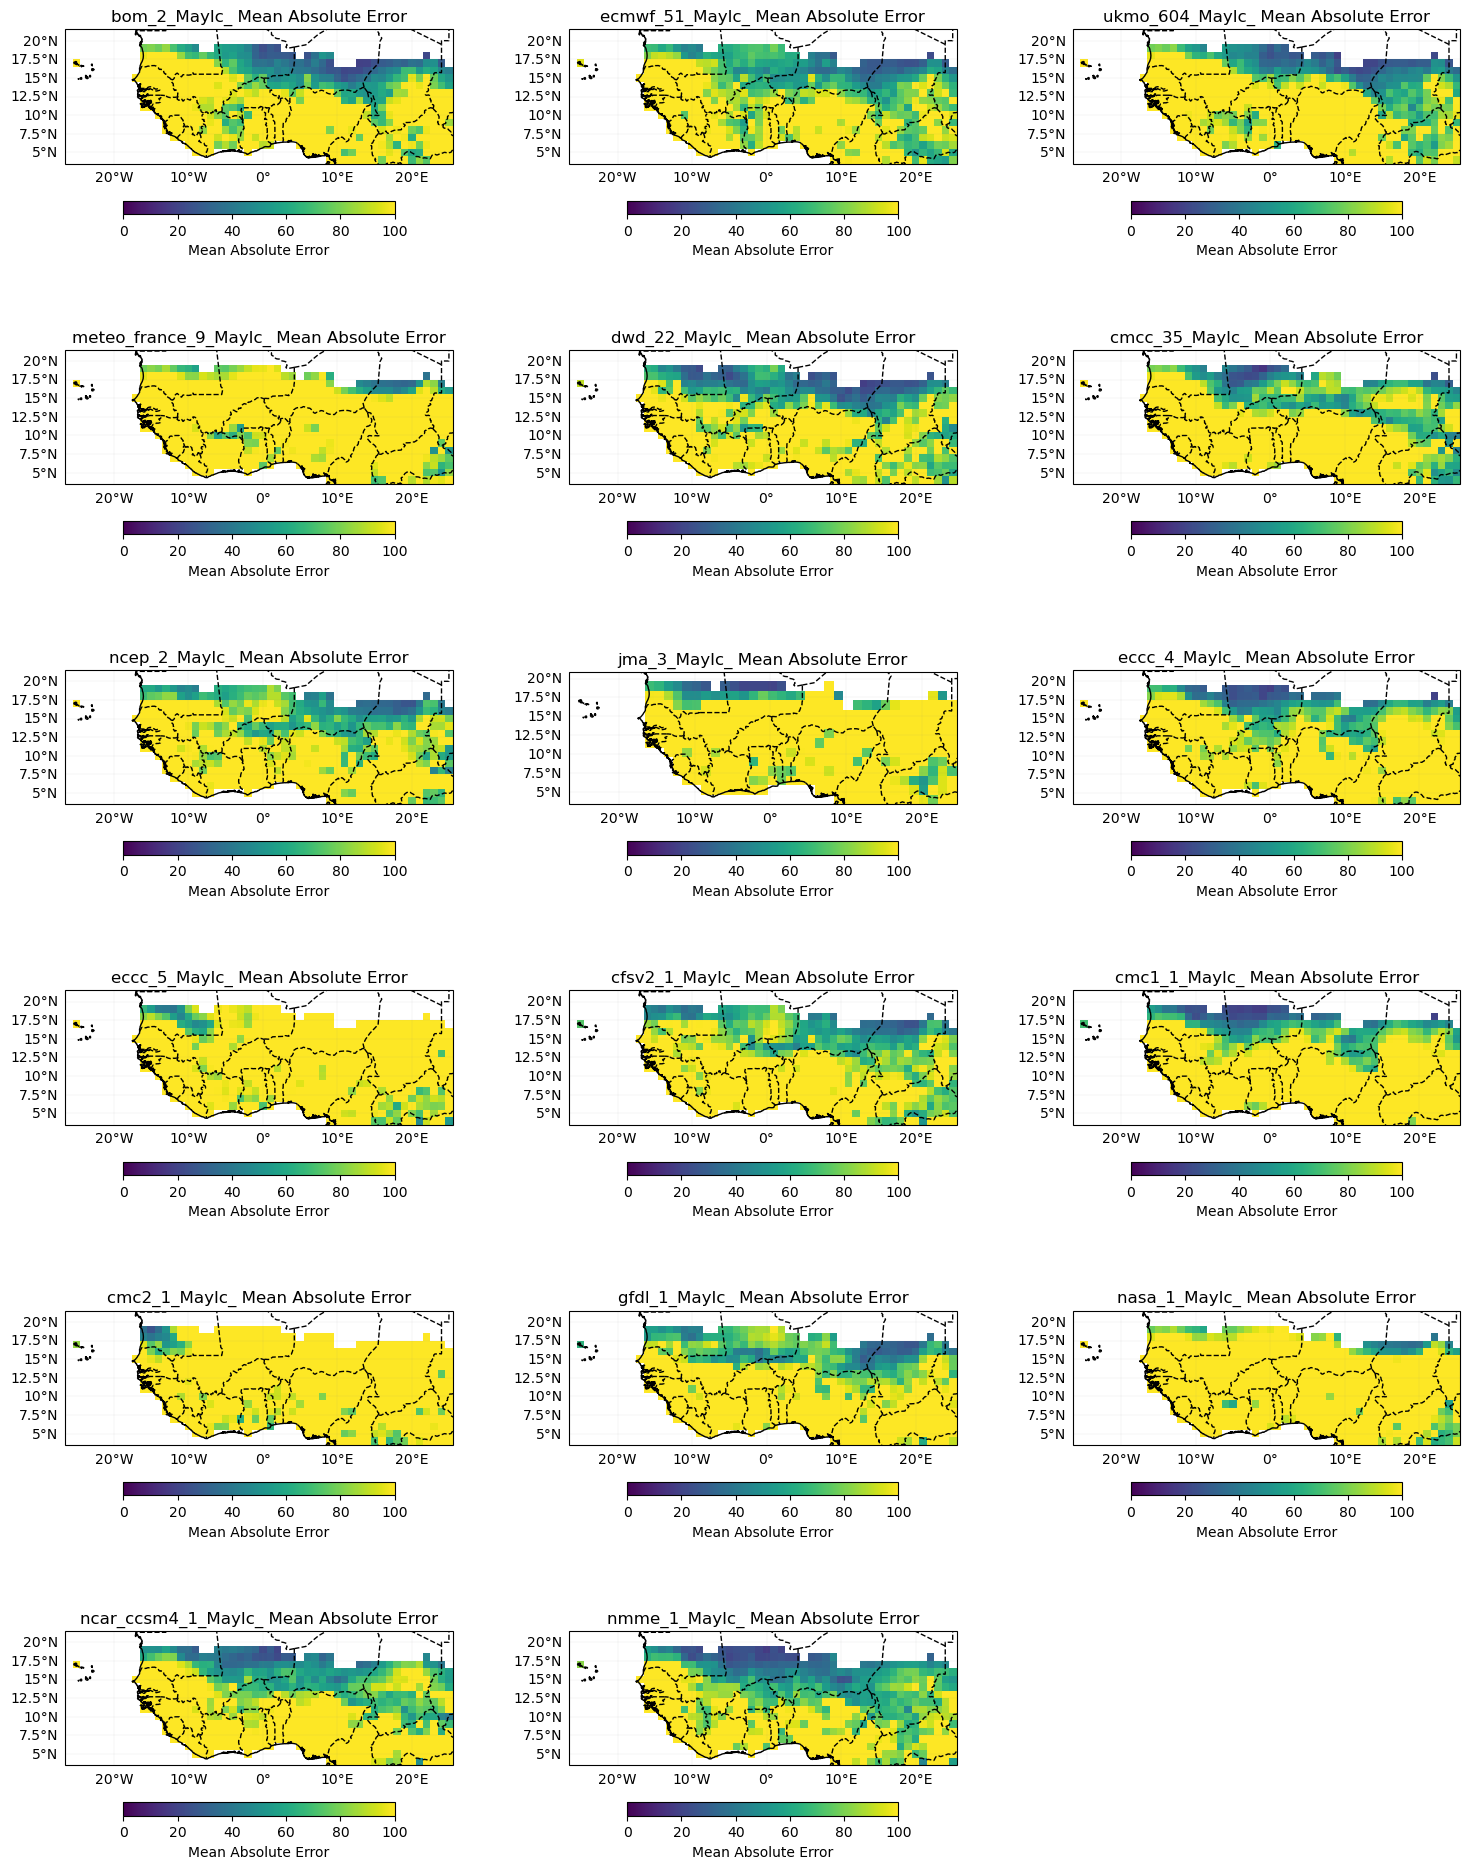

Generalized Discrimination Score


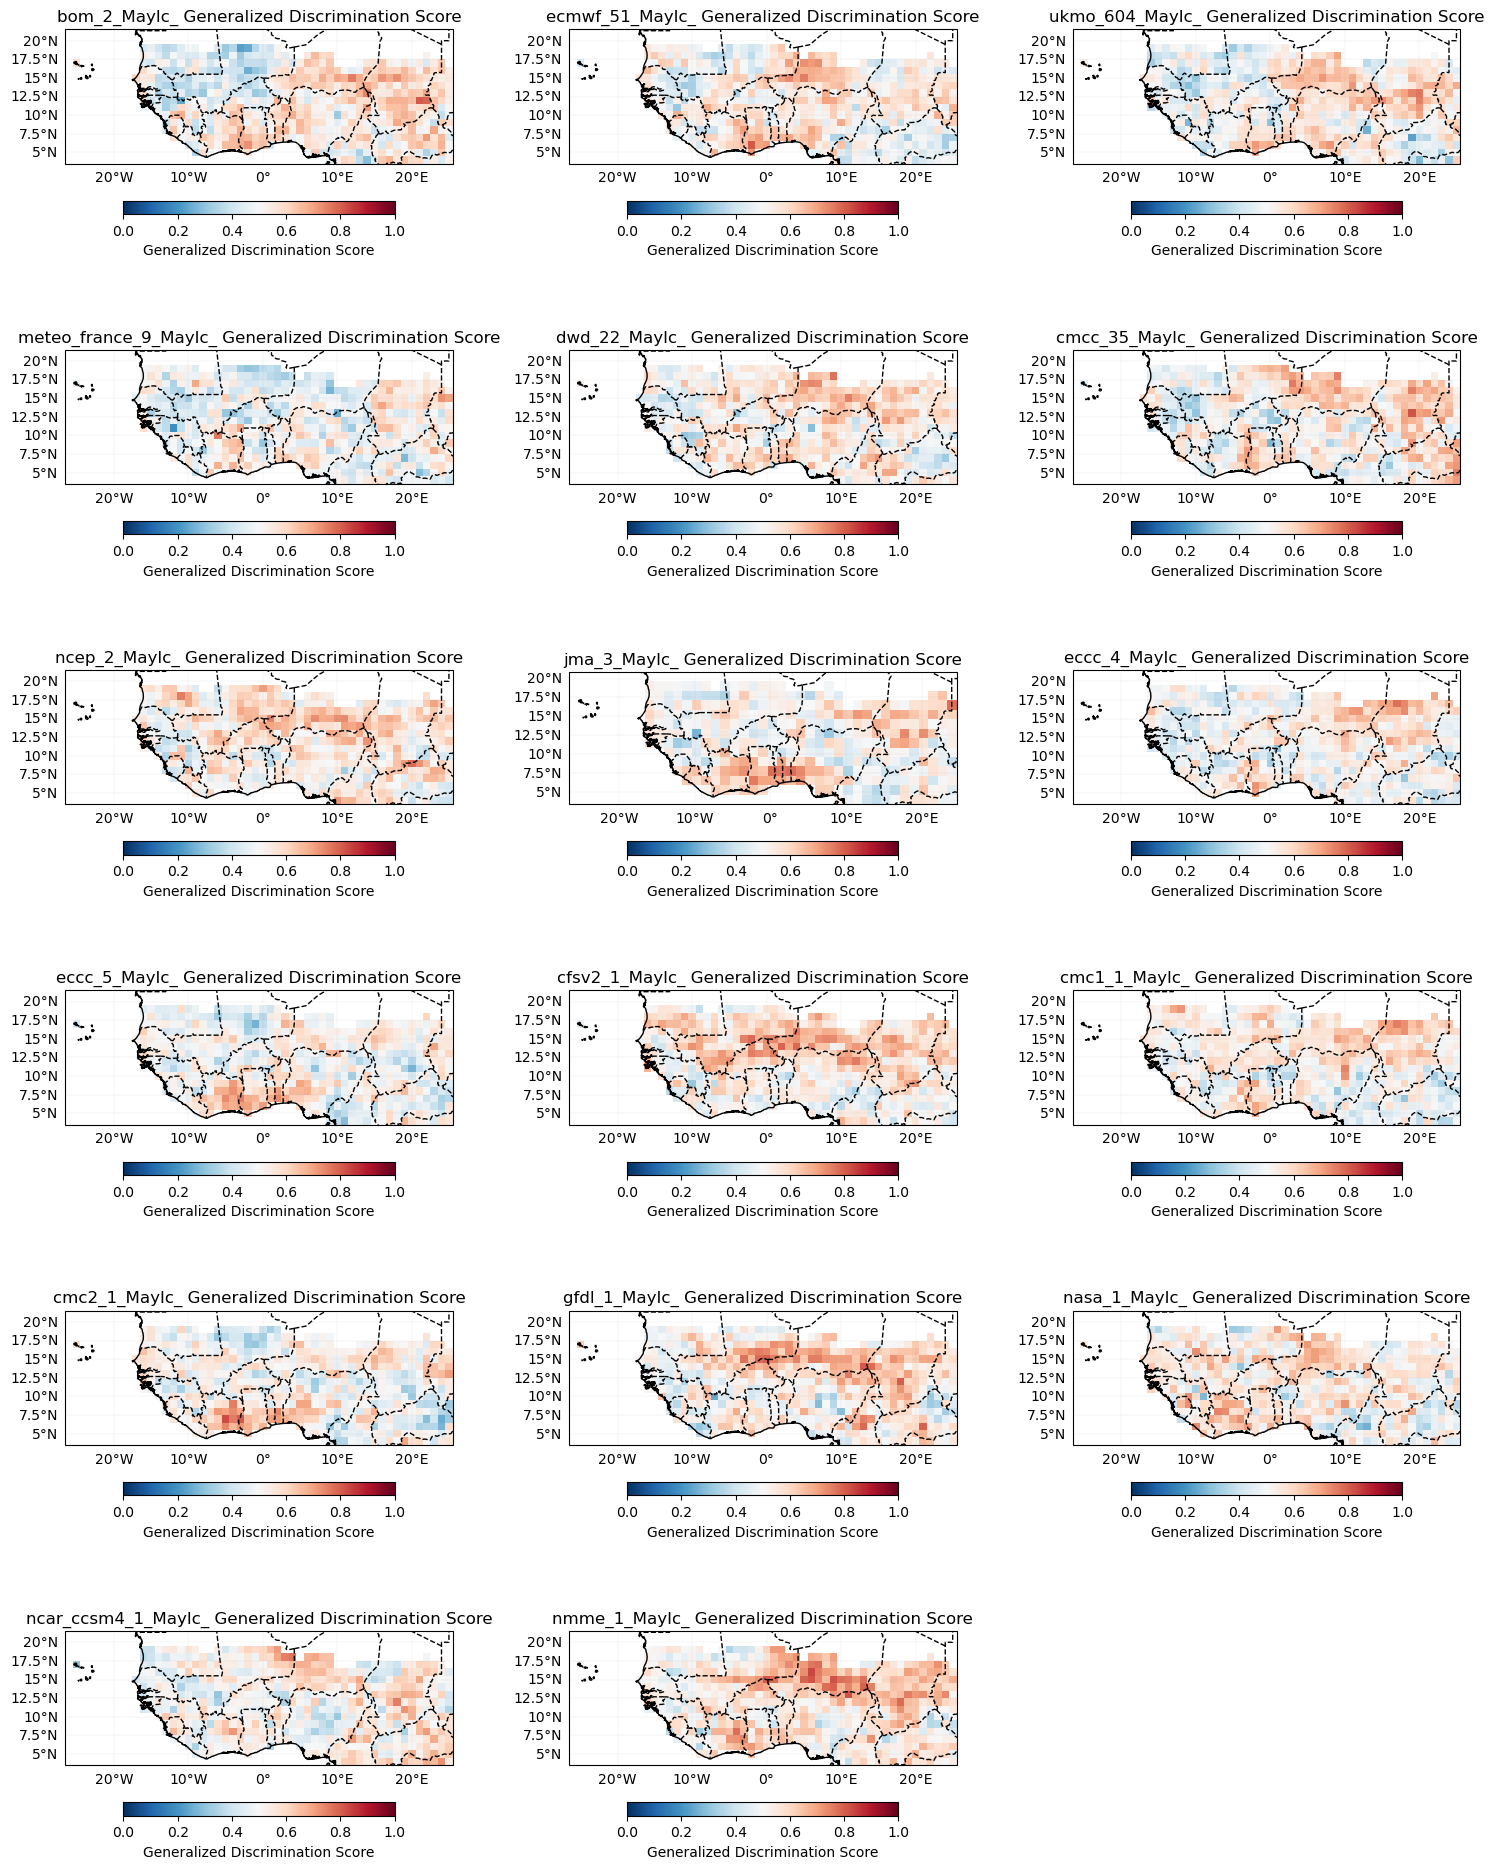

In [23]:
score = score.append('GROC') if 'GROC' not in score else score
os.makedirs(dir_save_score, exist_ok=True)
scores = {}
for i in score:
    scores[i] = was_verify.gcm_validation_compute(hindcast_files, rainfall, i, month_of_initialization, clim_year_start, clim_year_end, dir_save_score, lead_time = None, ensemble_mean=None, gridded=True)
    print(was_verify.scores[i][0])
    was_verify.plot_models_score(scores[i], i, dir_save_score)